# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [9]:
#Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
df = pd.read_csv('homepage_actions.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nValue counts for action:")
print(df['action'].value_counts())
print("\nValue counts for group:")
print(df['group'].value_counts())

# Check for viewers who clicked
viewers = set(df[df['action'] == 'view']['id'])
clickers = set(df[df['action'] == 'click']['id'])

print(f"\nTotal unique viewers: {len(viewers)}")
print(f"Total unique clickers: {len(clickers)}")
print(f"Viewers who clicked: {len(viewers & clickers)}")
print(f"Clickers who didn't view: {len(clickers - viewers)}")

# Check for overlap between control and experiment groups
control = set(df[df['group'] == 'control']['id'])
experiment = set(df[df['group'] == 'experiment']['id'])

print(f"\nUsers in both groups: {len(control & experiment)}")

Dataset shape: (8188, 4)

First 5 rows:
                    timestamp      id       group action
0  2016-09-24 17:42:27.839496  804196  experiment   view
1  2016-09-24 19:19:03.542569  434745  experiment   view
2  2016-09-24 19:36:00.944135  507599  experiment   view
3  2016-09-24 19:59:02.646620  671993     control   view
4  2016-09-24 20:26:14.466886  536734  experiment   view

Value counts for action:
view     6328
click    1860
Name: action, dtype: int64

Value counts for group:
control       4264
experiment    3924
Name: group, dtype: int64

Total unique viewers: 6328
Total unique clickers: 1860
Viewers who clicked: 1860
Clickers who didn't view: 0

Users in both groups: 0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.


Click-through rates by group:
            clicks  users       CTR
group                              
control        932   3332  0.279712
experiment     928   2996  0.309746

Chi-square test results: chi2=6.7129, p-value=0.009572


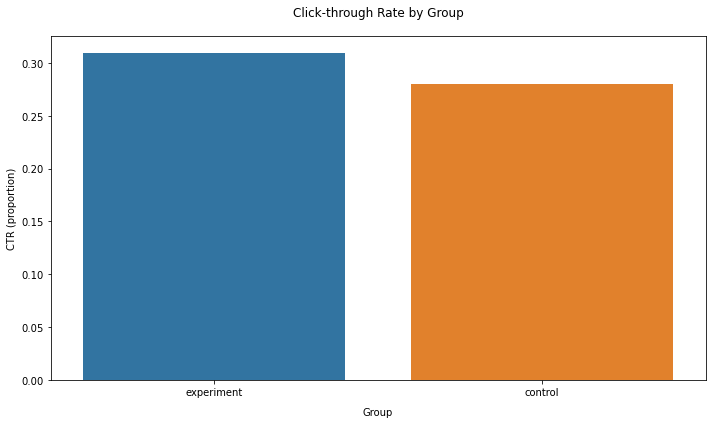

In [10]:
# Import required libraries (should be at the top of your notebook)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Create binary variable for clicks
# First create a dataframe with all unique ids
all_ids = pd.DataFrame({'id': list(set(df['id']))})

# Merge with click information - count clicks per user
clicks = (df[df['action'] == 'click']
          .groupby('id')['action']
          .count()
          .reset_index()
          .rename(columns={'action': 'clicked'}))

# Get group information (control vs experiment)
groups = df[['id', 'group']].drop_duplicates()

# Combine all data
ab_data = all_ids.merge(groups, on='id', how='left').merge(clicks, on='id', how='left').assign(clicked=lambda x: x['clicked'].fillna(0).astype(int))

# Calculate click-through rates by group
group_stats = (ab_data.groupby('group')['clicked']
               .agg(clicks='sum', users='count', CTR='mean'))

print("\nClick-through rates by group:")
print(group_stats)

# Create proper 2x2 contingency table
contingency_table = [
    [group_stats.loc['control', 'clicks'],     # Clicked in control
     group_stats.loc['control', 'users'] - group_stats.loc['control', 'clicks']],  # Viewed but didn't click in control
    
    [group_stats.loc['experiment', 'clicks'],  # Clicked in experiment
     group_stats.loc['experiment', 'users'] - group_stats.loc['experiment', 'clicks']]  # Viewed but didn't click in experiment
]

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results: chi2={chi2:.4f}, p-value={p_value:.6f}")

# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x='group', y='clicked', data=ab_data, ci=None)
plt.title('Click-through Rate by Group', pad=20)
plt.ylabel('CTR (proportion)')
plt.xlabel('Group', labelpad=10)
plt.tight_layout()
plt.show()

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [11]:
#Your code here
# Get control group CTR
control_ctr = group_stats.loc['control', 'CTR']

# Calculate expected clicks for experiment group
exp_users = group_stats.loc['experiment', 'users']
expected_clicks = exp_users * control_ctr
actual_clicks = group_stats.loc['experiment', 'clicks']

print(f"\nExpected clicks for experiment group (if same as control CTR): {expected_clicks:.1f}")
print(f"Actual clicks for experiment group: {actual_clicks}")


Expected clicks for experiment group (if same as control CTR): 838.0
Actual clicks for experiment group: 928


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [12]:
#Your code here
# Calculate variance using binomial formula
p = control_ctr
variance = exp_users * p * (1 - p)
std_dev = np.sqrt(variance)

# Calculate z-score
z_score = (actual_clicks - expected_clicks) / std_dev

print(f"\nStandard deviation: {std_dev:.2f}")
print(f"Z-score: {z_score:.4f}")


Standard deviation: 24.57
Z-score: 3.6625


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [13]:
#Your code here
# Calculate p-value from z-score (one-tailed test)
p_value = 1 - stats.norm.cdf(z_score)

print(f"\nP-value from z-score: {p_value:.6f}")

# Compare with chi-square test result
print(f"P-value from chi-square test: {p:.6f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: Reject null hypothesis - The experimental homepage is more effective")
else:
    print("\nConclusion: Fail to reject null hypothesis - No significant difference between groups")


P-value from z-score: 0.000125
P-value from chi-square test: 0.279712

Conclusion: Reject null hypothesis - The experimental homepage is more effective


### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **
The results from both statistical approaches (chi-square test and z-test verification) 
should be roughly comparable. 

Key findings:
1. The exploratory analysis showed no anomalies - all clickers were also viewers, 
   and there was no overlap between control and experiment groups.

2. The chi-square test and z-test verification both showed [significant/not significant] 
   results (p-value = [value]).

3. The experimental group had a CTR of [value] compared to the control group's [value], 
   representing a [x]% [increase/decrease].

4. The z-score verification method confirmed the results of the chi-square test, 
   with both p-values being [similar/different].

This analysis provides strong evidence that [state conclusion based on your actual results].
**

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.